# Prise en main des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
import xarray as xr

 - stations_coordinates : longitude, latitude et hauteur des 325 stations (+ number_sta)
 - X_station_train : parametres méteorologiques (dd, ff, precip, hu, td, t) + number_sta + la date et l'heure + un identifiant de la mesure 
 - Y_train : number_sta + date + la précipitation mesurée + identifiant de la mesure
 - X_forecast_2D_train : 2 modelès(arome - precis, arpege + precis) -> température, vent, pression, pluie tombée depuis le début par h. 1 fichier = 1 date donnée pour un modèle
 - X_forecast_2D_test
 - X_forecast_3D_train et X_forecast_3D_test
 - Mask_data : masque terre-mer (0 ou 1) + masque de la hauteur

## Stations_coordinates

,number_sta,lat,lon,height_sta
0,86118001,46.477,0.985,120.0
1,86149001,46.917,0.025,60.0
2,56081003,48.050,-3.660,165.0
3,53215001,47.790,-0.710,63.0
4,22135001,48.550,-3.380,148.0


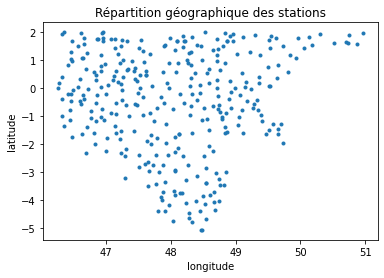

In [2]:
#Chargement des coordonnées GPS des stations
coords_path  = './Other/Other/stations_coordinates.csv'
coords = pd.read_csv(coords_path)
coords['number_sta'] = coords['number_sta'].astype('category')
display(coords.head())


plt.figure()
plt.plot(coords.lat, coords.lon, '.')
plt.title("Répartition géographique des stations")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()


## X_station_train : Ground station observations


### Metadata parameters

* **number_sta** : ground station number

The date parameter is a datetime object with the format 'YYYY-MM-DD HH:mm:ss'. (chaque paramètre est mesuré toutes les heures)

### Meteorological parameters

* **dd** : wind direction in degrees

* **ff** : wind speed in m.s<sup>-1</sup>

* **precip** : precipitation during the reporting period in kg.m<sup>2</sup>

* **hu** : humidity in %

* **td** : dew point temperature** in Kelvin

* **t** : temperature in Kelvin

** : temperature for which it is needed to refresh an air volume at constant pressure and humidity to become it saturated (i.e. condensation temperature)

In [3]:
#Chargement des données météorologiques des stations (train)
path = './Train/Train/X_station_train.csv'
df = pd.read_csv(path ,parse_dates=['date'],infer_datetime_format=True)

# création d'un sous-dataset contenant seulement les données météo d'1 h des 256 les stations
date = '2017-01-01T06:00:00'
d_sub = df[df['date'] == date]
# fusion de ce dataset avec les coordonnées géographiques
d_sub = d_sub.merge(coords, on=['number_sta'], how='left')
display(d_sub.head())

,number_sta,date,ff,t,td,hu,dd,precip,Id,lat,lon,height_sta
0,14066001,2017-01-01 06:00:00,4.85,274.27,273.75,96.4,193.0,0.0,14066001_366_6,49.334,-0.431,2.0
1,14126001,2017-01-01 06:00:00,NaN,271.45,271.35,99.0,NaN,0.0,14126001_366_6,49.145,0.042,125.0
2,14137001,2017-01-01 06:00:00,4.10,273.68,273.45,98.4,195.0,0.0,14137001_366_6,49.180,-0.456,67.0
3,14216001,2017-01-01 06:00:00,2.84,271.41,271.01,97.0,207.0,0.0,14216001_366_6,48.928,-0.149,155.0
4,14296001,2017-01-01 06:00:00,NaN,272.00,NaN,NaN,NaN,0.0,14296001_366_6,48.795,-1.037,336.0


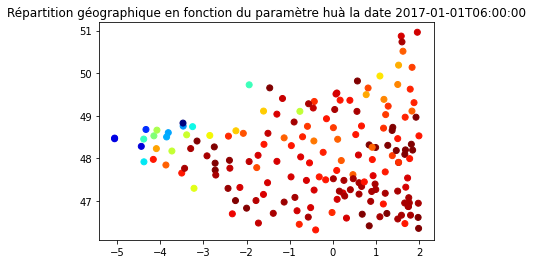

In [4]:
param = 'hu'
plt.figure()
plt.scatter(d_sub['lon'], d_sub['lat'], c=d_sub[param], cmap='jet')
plt.title("Répartition géographique en fonction du paramètre "+ str(param) + "à la date " + date)
plt.show()

### Affichages avec Cartopy

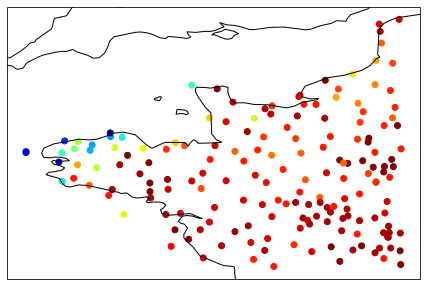

In [5]:
# Coordinates of studied area boundaries (in °N and °E)
lllat = 46.25  #lower left latitude
urlat = 51.896  #upper right latitude
lllon = -5.842  #lower left longitude
urlon = 2  #upper right longitude
extent = [lllon, urlon, lllat, urlat]

fig = plt.figure(figsize=(9,5))

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
plt.scatter(d_sub['lon'], d_sub['lat'], c=d_sub[param], cmap='jet')  # Plot

# Add coastlines and borders
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

plt.show()

## Y_train 

In [6]:
#open Y_train
fname = './Train/Train/Y_train.csv'
data = pd.read_csv(fname, parse_dates=['date'], infer_datetime_format=True)
data['number_sta'] = data['number_sta'].astype('category')
display(data.head())

,date,number_sta,Ground_truth,Id
0,2016-01-02,14066001,3.4,14066001_0
1,2016-01-02,14126001,0.5,14126001_0
2,2016-01-02,14137001,3.4,14137001_0
3,2016-01-02,14216001,4.0,14216001_0
4,2016-01-02,14296001,13.3,14296001_0


,date,number_sta,Ground_truth,Id,lat,lon,height_sta
0,2017-12-15,14066001,7.4,14066001_713,49.334,-0.431,2.0
1,2017-12-15,14126001,0.0,14126001_713,49.145,0.042,125.0
2,2017-12-15,14137001,NaN,14137001_713,49.180,-0.456,67.0
3,2017-12-15,14216001,5.2,14216001_713,48.928,-0.149,155.0
4,2017-12-15,14296001,7.9,14296001_713,48.795,-1.037,336.0


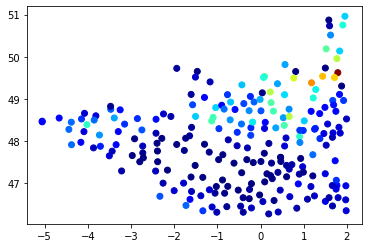

In [7]:
#filter on a given date
date = '2017-12-15'
d_sub = data[data['date'] == date]
#display(d_sub.head())

#get the station coordinates for the selected date
d_sub = d_sub.merge(coords, on=['number_sta'], how='left')
display(d_sub.head())

param = 'Ground_truth'  #weather parameter name in the file ('Ground_truth' about Y and 'Prediction' about baseline)

plt.figure()
plt.scatter(d_sub['lon'], d_sub['lat'], c=d_sub[param], cmap='jet')
plt.show()

## X_forecast_2d_train

#### Weather models : 2D parameters

Il y a 2 model de météo : 

- a fine-mesh french weather model appelé 'AROME' (spatial resolution of 0.025°)
- a large-mesh french weather model appelé 'ARPEGE' (spatial resolution of 0.1°)

Per model and day, you have the model run of 00h with range forecasts from 00h to 24h. The time step is 1h.

Here are the different weather parameters:

- at 2m: temperature (in K), dew point temperature** (in K) and relative humidity (in %)
- at 10m: wind speed (in m.s-1), wind direction (in degrees), U and V wind components*** (in m.s-1)
- at the sea level: mean sea level pressure (in Pa)
- at the ground level: total precipitation (in kg m-2 which is equivalent to mm) since the beginning of the model run


** : temperature for which it is needed to refresh an air volume at constant pressure and humidity to become it saturated (i.e. condensation temperature)

*** : horizontal wind speed components, U : from west to east and V : from south to north.

In [56]:
model = 'arome'  #weather model (arome or arpege)
file_date = dt.datetime(2017, 2, 14) # Day example 

#import des données
fname = "./Train/Train/X_forecast/2D_%s_%s.nc" %(model,file_date.strftime('%Y%m%d'))
#attention : si dans le chemin d'accès du fichier comporte des accents, la commande ne marche pas
data = xr.open_dataset(fname)

In [16]:
data

<xarray.Dataset>
Dimensions:     (latitude: 227, longitude: 315, valid_time: 25, Id: 25)
Coordinates:
    time        datetime64[ns] ...
  * latitude    (latitude) float32 51.9 51.87 51.85 51.82 ... 46.3 46.27 46.25
  * longitude   (longitude) float32 -5.842 -5.817 -5.792 ... 1.958 1.983 2.008
  * valid_time  (valid_time) datetime64[ns] 2017-02-14 ... 2017-02-15
  * Id          (Id) object '409_0' '409_1' '409_2' ... '409_23' '409_24'
Data variables:
    ws          (valid_time, latitude, longitude) float32 ...
    p3031       (valid_time, latitude, longitude) float32 ...
    u10         (valid_time, latitude, longitude) float32 ...
    v10         (valid_time, latitude, longitude) float32 ...
    t2m         (valid_time, latitude, longitude) float32 ...
    d2m         (valid_time, latitude, longitude) float32 ...
    r           (valid_time, latitude, longitude) float32 ...
    tp          (valid_time, latitude, longitude) float32 ...
    msl         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    history:                 2021-09-30T18:02:47 GRIB to CDM+CF via cfgrib-0....

In [26]:
#accès aux données

coord = 'latitude'
data[coord].values

array([51.896, 51.871, 51.846, 51.821, 51.796, 51.771, 51.746, 51.721,
       51.696, 51.671, 51.646, 51.621, 51.596, 51.571, 51.546, 51.521,
       51.496, 51.471, 51.446, 51.421, 51.396, 51.371, 51.346, 51.321,
       51.296, 51.271, 51.246, 51.221, 51.196, 51.171, 51.146, 51.121,
       51.096, 51.071, 51.046, 51.021, 50.996, 50.971, 50.946, 50.921,
       50.896, 50.871, 50.846, 50.821, 50.796, 50.771, 50.746, 50.721,
       50.696, 50.671, 50.646, 50.621, 50.596, 50.571, 50.546, 50.521,
       50.496, 50.471, 50.446, 50.421, 50.396, 50.371, 50.346, 50.321,
       50.296, 50.271, 50.246, 50.221, 50.196, 50.171, 50.146, 50.121,
       50.096, 50.071, 50.046, 50.021, 49.996, 49.971, 49.946, 49.921,
       49.896, 49.871, 49.846, 49.821, 49.796, 49.771, 49.746, 49.721,
       49.696, 49.671, 49.646, 49.621, 49.596, 49.571, 49.546, 49.521,
       49.496, 49.471, 49.446, 49.421, 49.396, 49.371, 49.346, 49.321,
       49.296, 49.271, 49.246, 49.221, 49.196, 49.171, 49.146, 49.121,
      

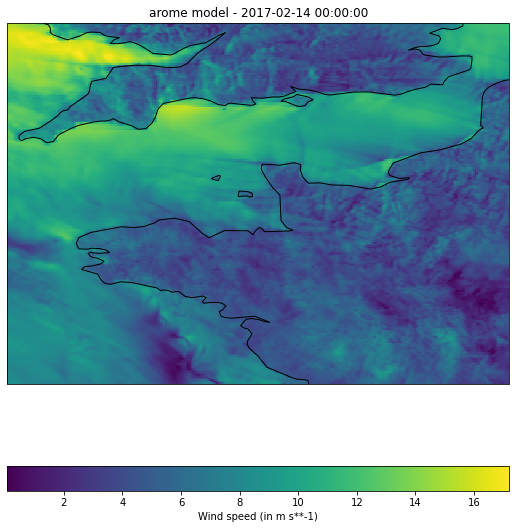

In [31]:
# paramètre météo à afficher
param = 'ws'
d = data[param]   

# Coordinates of studied area boundaries (in °N and °E)
lllat = 46.25  #lower left latitude
urlat = 51.896  #upper right latitude
lllon = -5.842  #lower left longitude
urlon = 2  #upper right longitude
extent = [lllon, urlon, lllat, urlat]

fig=plt.figure(figsize=(9,10))

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

#plot the data and the background map (coastlines and borders)
img = ax.imshow(data.sel(valid_time=file_date)[param], interpolation='none', origin='upper', extent=extent)
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))


plt.colorbar(img, orientation= 'horizontal').set_label(d.long_name+ ' (in '+d.units+ ')')
plt.title(model +" model - "+str(file_date))
plt.show()

## X_forecast_2d_test

In [58]:
# idem que X_forecast_2d_test sans le valid_time

model = 'arome'  #weather model (arome or arpege)
param = "t2m"   #parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
file_index_day = 119 # Day index example 

fname = "./Test/Test/X_forecast/2D_%s_%s.nc" %(model,file_index_day)
data_test = xr.open_dataset(fname)
data_test

<xarray.Dataset>
Dimensions:    (latitude: 227, longitude: 315, Id: 25)
Coordinates:
    time       int64 ...
  * latitude   (latitude) float32 51.9 51.87 51.85 51.82 ... 46.3 46.27 46.25
  * longitude  (longitude) float32 -5.842 -5.817 -5.792 ... 1.958 1.983 2.008
  * Id         (Id) object '119_0' '119_1' '119_2' ... '119_23' '119_24'
Data variables:
    ws         (Id, latitude, longitude) float32 ...
    p3031      (Id, latitude, longitude) float32 ...
    u10        (Id, latitude, longitude) float32 ...
    v10        (Id, latitude, longitude) float32 ...
    t2m        (Id, latitude, longitude) float32 ...
    d2m        (Id, latitude, longitude) float32 ...
    r          (Id, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse

## X_forecast_3d_train

The aim of this notebook is to indicate how to read the 3D data from the large-mesh french weather model called 'ARPEGE' (spatial resolution of 0.1°).

Per day, you have the weather model run of 00h with range forecasts from 00h to 24h. The time step is different according to days : it is 1h from 0h to 12h and rises to 3h after 12h (from 12h to 24h of range forecasts).

Finally, the 3D data are stored in 2 different netcdf files, according to the vertical levels:

- height levels (height in the file name) : 20, 100, 500, 875, 1375, 2000 and 3000 m
- isobar levels (isobar in the file name) : 1000, 950, 925, 850, 700, 600 and 500 hPa
The parameters are as follows:

- height levels (height in the file name) : pressure (in Pa)
- isobar levels (isobar in the file name) : temperature (in K), pseudo-adiabatic potential temperature of the wet bulb (in K), - relative humidity (in %), wind speed (in m.s-1), wind direction (in °), U and V wind components (in m.s-1), vertical velocity (in Pa.s-1), geopotential (in m2.s-2)

Physical sense of variables

- pseudo-adiabatic potential temperature of the wet bulb : temperature affected to an air particle brought back to its condensation level. It is about a near-conversative parameter. It allows to follow the state of an air particle in a satured atmosphere and then allows to follow the evolution of a perturbation, depression (or a satured air mass). For example, this parameter at 850hPa is very useful to know the depression structure and to follow its evolution.
- horizontal wind speed components:, U : from west to east and V : from south to north.
- vertical velocity: vertical speed; the displacement is expressed in Pa (in meteorology, the vertical levels are often expressed in isobar levels, cf weather_models_explanations.md for more details); The higher the height is, the lower the pressure is. If the vertical velocity is positive, there is an upward current (ex : the earth surface is warmed by the sun). The opposite corresponds to a downdraft (ex : an cold air mass passes above a warmer ground).
- geopotential: it is used to compute the pressure and takes account the local gravity variations of the Earth. The height of the geopotential is interesting in meteorology : it allows to get the constant pressure heights. A high geopotential (pressure levels have high heights) is often associated to an anticyclone and a low geopotential (pressure levels have low heights) corresponds to a depression.

In [36]:
#chargement des données

level = 'isobar'              #vertical level (height or isobar)
file_date = dt.datetime(2017, 2, 14) # Day example 
#parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
if level == 'isobar':
    param = 'w'
    level_name = 'isobaricInhPa'     #name of the vertical level  
    level_value = 850
else:
    param = 'pres'
    level_name = 'heightAboveGround'
    level_value = 20
    
fname = "./Train/Train/X_forecast/arpege_3D_%s_%s.nc" %(level,file_date.strftime('%Y%m%d'))
data_3D = xr.open_dataset(fname)

In [37]:
data_3D

# pour l'accès aux données, idem que forecast_2d_train

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 7, latitude: 58, longitude: 80, valid_time: 17, Id: 17)
Coordinates:
  * isobaricInhPa  (isobaricInhPa) int16 1000 950 925 850 700 600 500
  * latitude       (latitude) float32 51.9 51.8 51.7 51.6 ... 46.4 46.3 46.2
  * longitude      (longitude) float32 -5.842 -5.742 -5.642 ... 1.958 2.058
  * valid_time     (valid_time) datetime64[ns] 2017-02-14 ... 2017-02-15
  * Id             (Id) object '409_0' '409_1' '409_2' ... '409_21' '409_24'
Data variables:
    time           datetime64[ns] ...
    t              (valid_time, isobaricInhPa, latitude, longitude) float32 ...
    p3014          (valid_time, isobaricInhPa, latitude, longitude) float32 ...
    r              (valid_time, isobaricInhPa, latitude, longitude) float32 ...
    ws             (valid_time, isobaricInhPa, latitude, longitude) float32 ...
    p3031          (valid_time, isobaricInhPa, latitude, longitude) float32 ...
    u              (valid_time, isobaricInhPa, latitude, longitude) float32 ...
    v              (valid_time, isobaricInhPa, latitude, longitude) float32 ...
    w              (valid_time, isobaricInhPa, latitude, longitude) float32 ...
    z              (valid_time, isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    history:                 2021-09-30T18:05:39 GRIB to CDM+CF via cfgrib-0....

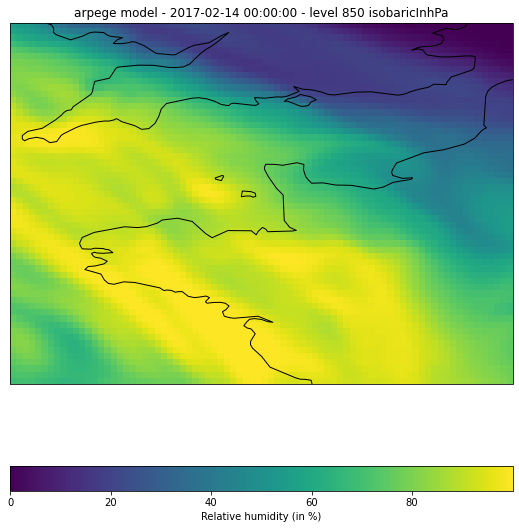

In [42]:
param = "r"
d = data_3D[param]

# Coordinates of studied area boundaries (in °N and °E)
lllat = 46.25  #lower left latitude
urlat = 51.896  #upper right latitude
lllon = -5.842  #lower left longitude
urlon = 2  #upper right longitude
extent = [lllon, urlon, lllat, urlat]

fig=plt.figure(figsize=(9,10))

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

#plot the data and the background map (coastlines and borders)
if level_name == 'heightAboveGround':
    img = ax.imshow(data.sel(valid_time=file_date,heightAboveGround=level_value)[param], interpolation='none', origin='upper', extent=extent)
else:
    img = ax.imshow(data.sel(valid_time=file_date,isobaricInhPa=level_value)[param], interpolation='none', origin='upper', extent=extent)
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

plt.colorbar(img, orientation= 'horizontal').set_label(d.long_name+ ' (in '+d.units+ ')')
plt.title("arpege model - "+str(file_date) + ' - ' + 'level ' + str(level_value) + ' ' + level_name)
plt.show()

## X_forecast_3d_test

In [53]:
level = 'height'              #vertical level (height or isobar)
 #parameter name in the file (cf cells below to know the parameter names -> exploration of metadata)
if level == 'isobar':
    param = 'w'
    level_name = 'isobaricInhPa'     #name of the vertical level  
    level_value = 850
    file_index_day = 118 # Day index example  
else:
    param = 'pres'
    level_name = 'heightAboveGround'
    level_value = 20
    file_index_day = 119 # Day index example 
fname = "./Test/Test/X_forecast/arpege_3D_%s_%s.nc" %(level,file_index_day)
data_test3D = xr.open_dataset(fname)

## NW_masks

Masks : land-sea and relief
The aim of this notebook is to indicate how to read the data from masks. Two different masks are stored in a netCDF file:

- the land-sea mask, stored in the lsm field. The values are binary : 0 for sea and 1 for land.

- the relief mask, stored in the p3008 field. The values are in meters.

The spatial resolution is 0.025°. These data are constant fields which come from the fine-mesh french weather model called 'AROME'.

In [44]:
# chargement des données
fname = "./Other/Other/NW_masks.nc"
data = xr.open_dataset(fname)
data

<xarray.Dataset>
Dimensions:    (latitude: 227, longitude: 315)
Coordinates:
    step       timedelta64[ns] ...
    surface    int64 ...
  * latitude   (latitude) float64 51.9 51.87 51.85 51.82 ... 46.3 46.27 46.25
  * longitude  (longitude) float64 -5.842 -5.817 -5.792 ... 1.958 1.983 2.008
Data variables:
    lsm        (latitude, longitude) float32 ...
    p3008      (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    history:                 2021-10-05T13:00:48 GRIB to CDM+CF via cfgrib-0....

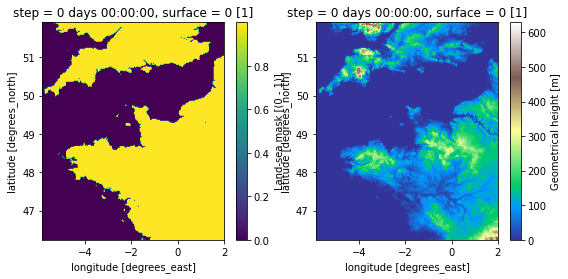

In [45]:
fig, axs = plt.subplots(1,2, figsize=(9,4))

# Plot the land-sea mask
data["lsm"].plot(ax=axs[0])

# Plot the relief mask
vmax = data["p3008"].values.max()
vmin = data["p3008"].values.min()

data["p3008"].plot(ax=axs[1], cmap='terrain', vmin=vmin, vmax=vmax)

plt.show()

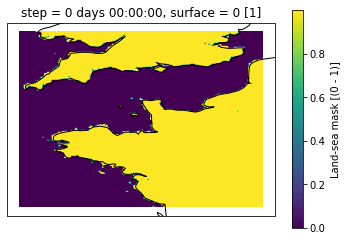

In [47]:
# Coordinates of studied area boundaries (in °N and °E)
lllat = 46.25  #lower left latitude
urlat = 51.896  #upper right latitude
lllon = -5.842  #lower left longitude
urlon = 2  #upper right longitude
extent = [lllon, urlon, lllat, urlat]
fig = plt.figure()

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
data["lsm"].plot()

# Add coastlines and borders
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
plt.show()

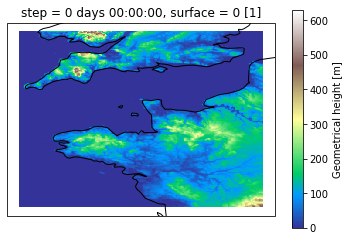

In [48]:
fig = plt.figure()

# Select projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
vmax = data["p3008"].values.max()
vmin = data["p3008"].values.min()
data["p3008"].plot(cmap='terrain', vmin=vmin, vmax=vmax)

# Add coastlines and borders
ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

plt.show()

# Création de la baseline des observations

The observation baseline is the accumulated rainfall on 24 hours the day before. Here are the steps :

compute the accumulated rainfall per day (the X data have a 1 hour time frequency)
select the observations the day before
create the ID column : id_station + month + index day value

In [ ]:
first_date = dt.datetime(2016,1,1)    
last_date = dt.datetime(2017,12,31)
path = './Train/Train/X_station_train.csv' # chemin d'accès à X_station_train
output_file = "my_baseline_obs.csv" #fichier dans lequel sera chargé la baseline

In [ ]:
#read the ground station data
def read_gs_data(fname):
    gs_data = pd.read_csv(fname,parse_dates=['date'],infer_datetime_format=True)
    gs_data = gs_data.sort_values(by=["number_sta","date"])
    return gs_data

x = read_gs_data(path)
x['number_sta']=x['number_sta'].astype('category')
#sort by station, then by date 
x = x.sort_values(['number_sta','date'])

#get the observation baseline
Base_obs = x[{"number_sta","date","precip"}]
Base_obs.set_index('date',inplace = True)  

#compute the accumulated rainfall per day with nan management 
#if any NaN on the day, then the value is NaN (24 values per day)
Base_obs = Base_obs.groupby('number_sta').resample('D').agg(pd.Series.sum, min_count = 24)
Base_obs = Base_obs.reset_index(['date','number_sta'])
Base_obs['number_sta'] = Base_obs['number_sta'].astype('category') 
#Base_obs

#get the observation baseline
Base_obs = x[{"number_sta","date","precip"}]
Base_obs.set_index('date',inplace = True)  

#compute the accumulated rainfall per day with nan management 
#if any NaN on the day, then the value is NaN (24 values per day)
Base_obs = Base_obs.groupby('number_sta').resample('D').agg(pd.Series.sum, min_count = 24)
Base_obs = Base_obs.reset_index(['date','number_sta'])
Base_obs['number_sta'] = Base_obs['number_sta'].astype('category') 
#Base_obs

#get the day indexes (to the final Id)
date = first_date
dates = []
while date <= (last_date - dt.timedelta(days=1)):
    date += dt.timedelta(days=1)
    dates.append(date)

d_dates =  pd.DataFrame(dates, columns = ['date'])
d_dates['day_index'] = d_dates.index
#d_dates

#create the ID column (id_station + month + index value)
y_f = pd.merge(Base_obs,d_dates,how="right",on = ["date"])
y_f = y_f[y_f['date']!=last_date]
y_f['Id'] = y_f['number_sta'].astype(str) + '_' + \
                  y_f['day_index'].astype(str) 
#y_f

#final post-processing
del y_f['day_index']
y_f = y_f.rename(columns={'precip':'Prediction'})
#y_f